In [1]:
import csv, sqlite3

In [2]:
con = sqlite3.connect("NFL_STATS.db")
cur = con.cursor()

In [3]:
!pip install pandas
!pip install ipython-sql prettytable

import prettytable
prettytable.DEFAULT = 'DEFAULT'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [4]:
!pip install ipython-sql
%load_ext sql

In [7]:
import pandas as pd
import sqlite3
from google.colab import files
import re

# --- Connect to SQLite database ---
con = sqlite3.connect("NFL_STATS.db")

# --- Drop existing tables if they exist ---
tables_to_drop = ["NFL_2008", "NFL_2009","NFL_2010", "NFL_2011", "NFL_2012", "NFL_2013", "NFL_2014", "NFL_2015","NFL_2004", "NFL_2005", "NFL_2006", "NFL_2007" ]
for table in tables_to_drop:
    con.execute(f"DROP TABLE IF EXISTS {table}")
    print(f"Dropped table {table} if it existed.")

# --- Upload my CSV files ---
uploaded = files.upload()  # Select your CSV files

# --- Import each CSV with cleaned table names ---
for file in uploaded.keys():
    # Clean table name: remove .csv, spaces, parentheses, numeric suffixes like (1)
    table_name = re.sub(r"\s*\(\d+\)", "", file)
    table_name = table_name.replace(".csv", "").replace(" ", "_")

    # Read CSV
    df = pd.read_csv(file)

    # Clean 'QB' column if it exists
    if 'qb' in df.columns:
      df['qb'] = df['qb'].str.extract(r'^([A-Za-z]+\s[A-Za-z]+)')
      df['qb'] = df['qb'].str[:-1]

    # Import into SQLite
    df.to_sql(table_name, con, if_exists='replace', index=False, method="multi")
    print(f"Imported {file} as table {table_name}")

# --- Verify all tables ---
tables = con.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
print("Tables in database:", [t[0] for t in tables])


Dropped table NFL_2008 if it existed.
Dropped table NFL_2009 if it existed.
Dropped table NFL_2010 if it existed.
Dropped table NFL_2011 if it existed.
Dropped table NFL_2012 if it existed.
Dropped table NFL_2013 if it existed.
Dropped table NFL_2014 if it existed.
Dropped table NFL_2015 if it existed.
Dropped table NFL_2004 if it existed.
Dropped table NFL_2005 if it existed.
Dropped table NFL_2006 if it existed.
Dropped table NFL_2007 if it existed.


Saving QBStats_2009.csv to QBStats_2009.csv
Saving QBStats_2004.csv to QBStats_2004.csv
Saving QBStats_2007.csv to QBStats_2007.csv
Saving QBStats_2005.csv to QBStats_2005.csv
Saving QBStats_2008.csv to QBStats_2008.csv
Saving QBStats_2010.csv to QBStats_2010.csv
Saving QBStats_2006.csv to QBStats_2006.csv
Saving QBStats_2014.csv to QBStats_2014.csv
Saving QBStats_2016.csv to QBStats_2016.csv
Saving QBStats_2011.csv to QBStats_2011.csv
Saving QBStats_2012.csv to QBStats_2012.csv
Saving QBStats_2015.csv to QBStats_2015.csv
Saving QBStats_2013.csv to QBStats_2013.csv
Imported QBStats_2009.csv as table QBStats_2009
Imported QBStats_2004.csv as table QBStats_2004
Imported QBStats_2007.csv as table QBStats_2007
Imported QBStats_2005.csv as table QBStats_2005
Imported QBStats_2008.csv as table QBStats_2008
Imported QBStats_2010.csv as table QBStats_2010
Imported QBStats_2006.csv as table QBStats_2006
Imported QBStats_2014.csv as table QBStats_2014
Imported QBStats_2016.csv as table QBStats_2

In [8]:
%sql sqlite:///NFL_STATS.db

In [9]:
%sql SELECT * from QBStats_2011 limit(1)

 * sqlite:///NFL_STATS.db
Done.


qb,att,cmp,yds,ypa,td,int,lg,sack,loss,rate,game_points,home_away,year
Drew Brees,49,32,419,8.6,3,0,36,3,23,112.5,34,away,2011


In [10]:
%sql SELECT name,type,length(type) FROM PRAGMA_TABLE_INFO('QBStats_2009');

 * sqlite:///NFL_STATS.db
Done.


name,type,length(type)
qb,TEXT,4
att,INTEGER,7
cmp,INTEGER,7
yds,REAL,4
ypa,REAL,4
td,INTEGER,7
int,TEXT,4
lg,TEXT,4
sack,REAL,4
loss,REAL,4


# **Quarterback Trends Over The Years**
We will be taking a look at the major metrics of Quarterbacks over the years and take a look at the trends from 2004-2016. Given the results, we will make some assumptions and conclusions about why that is.

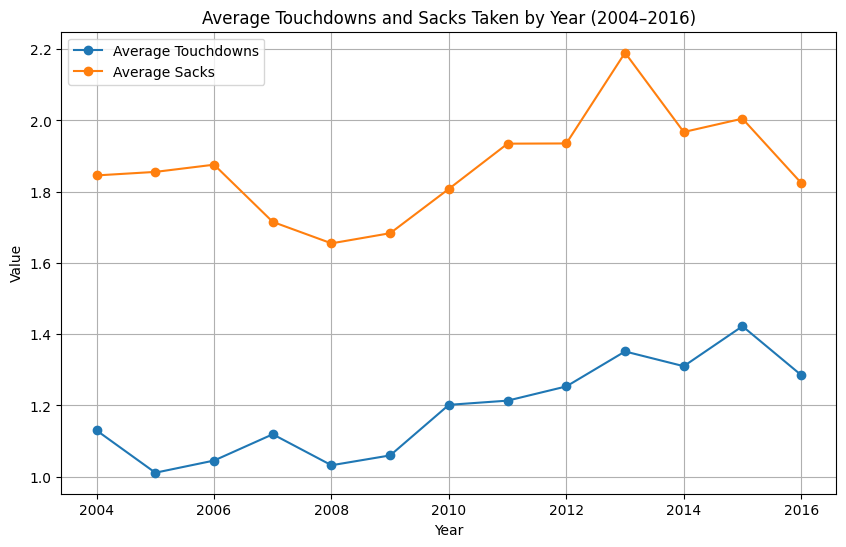

In [11]:

import matplotlib.pyplot as plt
years = list(range(2004, 2017))
data = []
for year in years:
    table = f"QBStats_{year}"
    query = f"SELECT AVG(td) as avg_td, AVG(sack) as avg_sack FROM {table}"
    try:
        avg_td, avg_sack = con.execute(query).fetchone()
        data.append((year, avg_td, avg_sack))
    except Exception as e:
        print(f"Could not query {table}: {e}")

df = pd.DataFrame(data, columns=["year", "avg_td", "avg_sack"])

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["avg_td"], marker="o", label = "Average Touchdowns")
plt.plot(df["year"], df["avg_sack"], marker="o", label = "Average Sacks")
plt.title("Average Touchdowns and Sacks Taken by Year (2004–2016)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

As the game started to modify the rules to help out the offense, the quarterback production, touchdown-wise, has increased dramatically in the 12 years shown above. It can be assumed that the trend has remained the same from 2017 to today, and quarterbacks are throwing nearly two scores per game. It is interesting to see that the sacks taken went up along with the touchdowns thrown. That means the improvement was not necessarily due to offensive lines getting better, but the offense being more aggressive. Offenses inclined to take big shots down the field will have QBs hold on to the ball more, which explains the number of sacks going up.

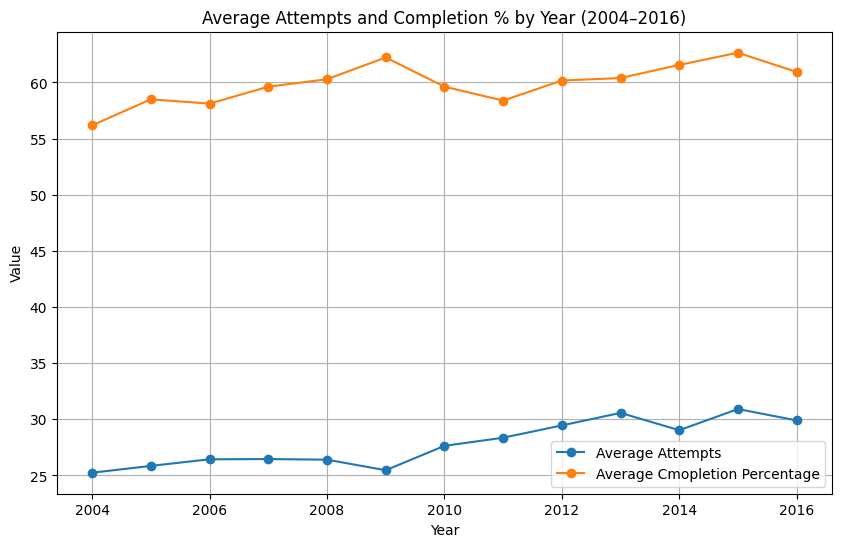

In [12]:

import matplotlib.pyplot as plt
years = list(range(2004, 2017))
data = []
for year in years:
    table = f"QBStats_{year}"
    query = f"SELECT AVG(att) as avg_att, AVG(CAST(cmp AS FLOAT) / NULLIF(att,0)) * 100 as avg_cmp_pct FROM {table}"
    try:
        avg_att, avg_cmp_pct = con.execute(query).fetchone()
        data.append((year, avg_att, avg_cmp_pct ))
    except Exception as e:
        print(f"Could not query {table}: {e}")

df = pd.DataFrame(data, columns=["year", "avg_att", "avg_cmp_pct"])

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["avg_att"], marker="o", label = "Average Attempts")
plt.plot(df["year"], df["avg_cmp_pct"], marker="o", label = "Average Completion Percentage")
plt.title("Average Attempts and Completion % by Year (2004–2016)")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()

This is plot gives a good explanation for the previous one above. With the game evolving in offensive creation, quarterbacks are encourged to throw more which speaks to why the touchdown numbers have increased so much. It is fascinating to see that there is a general overall upward trend in completion percentage, given that the passing attempts have increased. What do you guys think is the trend for interceptions?

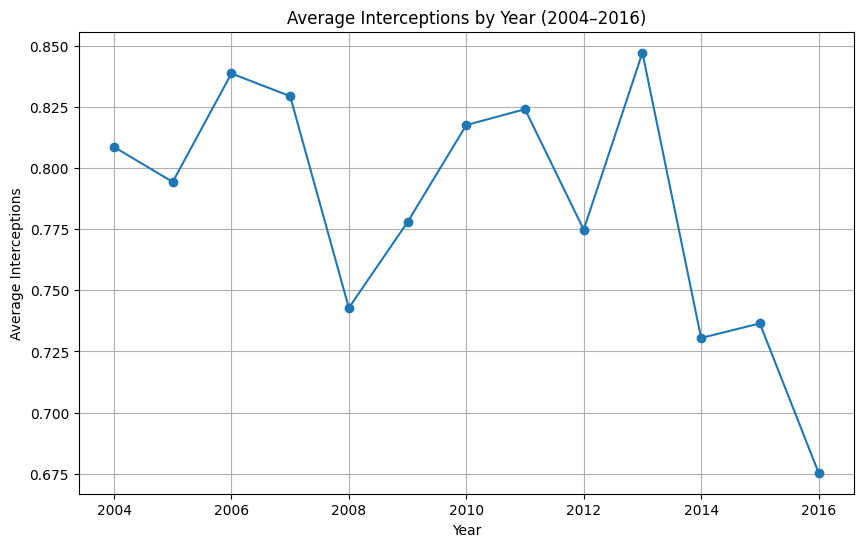

In [13]:

import matplotlib.pyplot as plt
years = list(range(2004, 2017))
data = []
for year in years:
    table = f"QBStats_{year}"
    query = f"SELECT AVG(int) as avg_int FROM {table}"
    try:
        avg_int = con.execute(query).fetchone()[0]
        data.append((year, avg_int))
    except Exception as e:
        print(f"Could not query {table}: {e}")

df = pd.DataFrame(data, columns=["year", "avg_int"])

plt.figure(figsize=(10,6))
plt.plot(df["year"], df["avg_int"], marker="o")
plt.title("Average Interceptions by Year (2004–2016)")
plt.xlabel("Year")
plt.ylabel("Average Interceptions")
plt.grid(True)
plt.show()

This is a jarring chart. With the increase in attempts it would be expeted that the interception numbers follow a similar path. With it being the exact opposite of the previous graphs it shows that it has become incredibly harder for defenses to stop opposing QBs. Factors such as more flags being thrown and offenses getting more creative could have led to this graph.

# **Quarterback Consistency In 2011**
 The 2011 NFL season saw a plethora of quarterbacks having career seasons. Drew Brees at the time, broke the NFL record for most passing yards in a season. Tom Brady continued his dominance, throwing for over 5,000 yards as well. Aaron Rodgers won MVP, cementing himself with the best passer rating ever in a season. Up and coming Lions QB Matthew Stafford was the third quarterback to throw north of 5,000 yards. It was fireworks from that position.
 Let's take a deeper dive into what their passer rating wa sgame by game and how they fared against each other and how they did compared to the rest of the league.

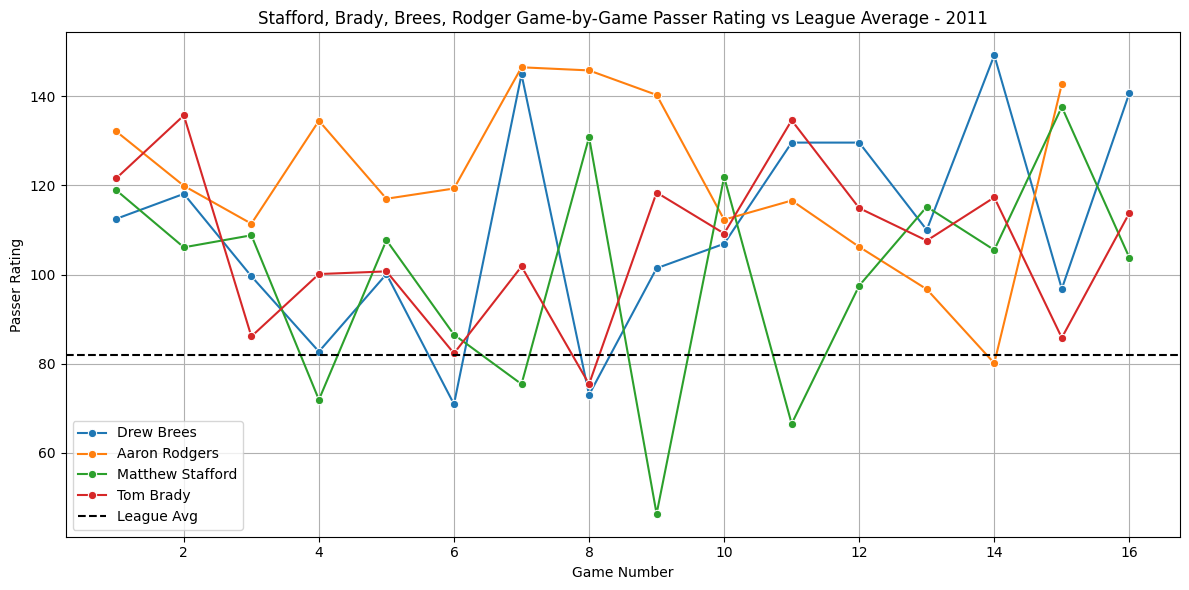

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

season = "QBStats_2011"
query = f"Select qb, rate from {season} where qb IN ('Matthew Stafford', 'Aaron Rodgers', 'Tom Brady', 'Drew Brees')"
results = con.execute(query).fetchall()
df = pd.DataFrame(results, columns=["qb","rate"])
df['game_number'] = df.groupby('qb').cumcount() + 1

query_all = f"SELECT rate FROM {season}"
results_all = con.execute(query_all).fetchall()
df_all = pd.DataFrame(results_all, columns=["rate"])
df_all['game_number'] = df_all.groupby(df_all.index // 1).cumcount() + 1


plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='game_number', y='rate', hue='qb', marker='o')
league_mean = df_all['rate'].mean()
plt.axhline(y=league_mean, color='black', linestyle='--', label='League Avg')
plt.xlabel("Game Number")
plt.ylabel("Passer Rating")
plt.title("Stafford, Brady, Brees, Rodger Game-by-Game Passer Rating vs League Average - 2011")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The graph above how dominant each of these quarterbacks were in comparison to the league average. The most jarring to see was Aaron Rodgers. His worst performance that year was around league average. He was either spectacuaalr or just as good as everyone else. That is unheard of.

# Peyton's Historic 2013 Season
Peyton Manning, in 2013, shattered all the single season quarterback records that one could think of. He threw for the most yards and touchdowns in a single season with 55 and 5477, respectively. In the first game that year, he had 7 touchdowns, which was tied for most in a game. It was an unprecedented season for him, and here we'll take a look at how he did compared to other quarterbacks.

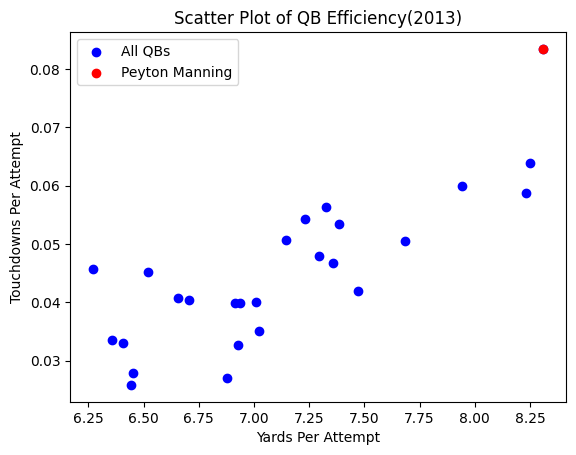

In [24]:
season = "QBStats_2013"
query = f"Select qb, SUM(yds) as total_yards, SUM(TD) as total_td, SUM(att) as total_att from {season} group by qb"
results = con.execute(query).fetchall()
df_2013 = pd.DataFrame(results, columns=["qb", "total_yards", "total_td", "total_att"])
df_2013["tdpa"] = df_2013["total_td"]/df_2013["total_att"]
df_2013["ypa"] = df_2013["total_yards"]/df_2013["total_att"]
df_2013 = df_2013[df_2013["total_att"]>325]
peyton_df_2013 = df_2013[df_2013['qb']=='Peyton Manning']

fig, ax = plt.subplots()
ax.scatter(df_2013['ypa'], df_2013['tdpa'], label='All QBs', color='blue')
ax.scatter(peyton_df_2013['ypa'], peyton_df_2013['tdpa'], label='Peyton Manning', color='red')

ax.set_xlabel('Yards Per Attempt')
ax.set_ylabel('Touchdowns Per Attempt')
ax.set_title('Scatter Plot of QB Efficiency(2013)')
ax.legend()

plt.show()


This graph shows how far and away Manning was better than everyone else that year. This is for quarterbacks who have thrown a minimum of 325 passes that season to avoid any skewed numbers or outliers.